In [1]:
import numpy as np
import netCDF4 as nc
import scipy.io as sio
from scipy import interpolate
import datetime
import matplotlib.pyplot as plt
import  matplotlib.cm as cm
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/modules/')
import functions_plot

[PrepareTS.ipynb](http://nbviewer.jupyter.org/urls/bitbucket.org/salishsea/tools/raw/tip/I_ForcingFiles/Initial/PrepareTS.ipynb)

# Observations
The salinity and temperature measurements were obtained from MC. There are 34 profiles. The shallow set has 21 profiles and the deep set has 13 profiles. The shallow set goes to 257 m depth, while the deep goes to 2046 m. In order to look at the data more easily, I joined both sets.

In [19]:
# Load two datasets
ts_data_shal = sio.loadmat('canyonTSdata.mat')
ts_data_deep = sio.loadmat('canyonTSdata2.mat')

# Extract important variables
longitudes = np.concatenate((ts_data_shal['loncanyon'][0], ts_data_deep['loncanyon2'][0]),axis=0)
latitudes = np.concatenate((ts_data_shal['latcanyon'][0], ts_data_deep['latcanyon2'][0]),axis=0)
years = np.concatenate((ts_data_shal['yrcanyon'][0], ts_data_deep['yrcanyon2'][0]),axis=0)
days = np.concatenate((ts_data_shal['daycanyon'][0], ts_data_deep['daycanyon2'][0]),axis=0)
con_temps = np.concatenate((ts_data_shal['tempcanyon'], ts_data_deep['tempcanyon2']),axis=1)
abs_salts = np.concatenate((ts_data_shal['salcanyon'], ts_data_deep['salcanyon2']),axis=1)
depths = np.concatenate((ts_data_shal['depthcanyon'], ts_data_deep['depthcanyon2']),axis=1) * -1

# Dates these measurements were taken
dates = []
for i in range(len(days)):
    date = (datetime.datetime(years[i], 1, 1) + datetime.timedelta(days[i] - 1)).strftime('%b %y')
    dates.append(date)

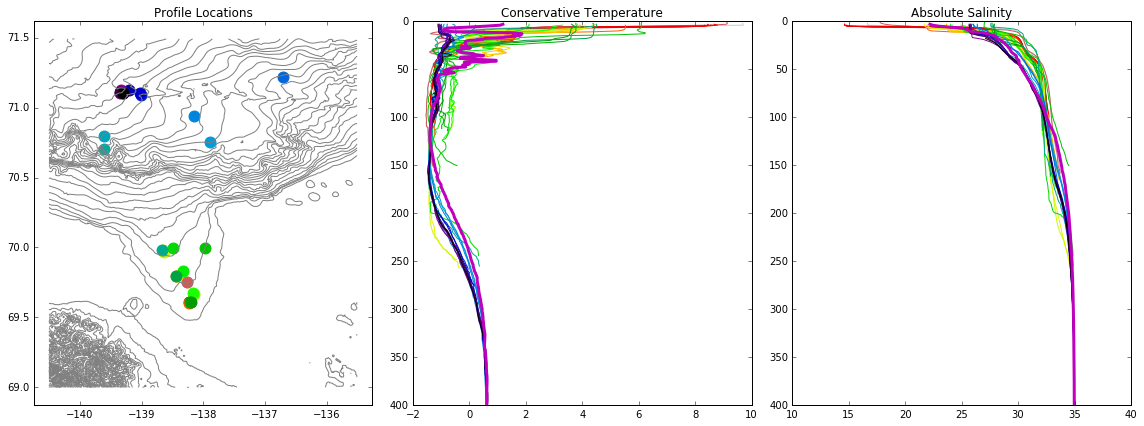

In [82]:
xg, yg, zg = functions_plot.get_variables('G')
xn, yn, zn = functions_plot.def_regionG(-140.5, -135.5, 69.0, 71.5)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,6))
ct = ax1.contour(xn, yn, zn, 60, colors='grey', linestyles='solid')

profiles = np.arange(34)
c = cm.nipy_spectral_r(np.linspace(0, 1, len(profiles)))
for ind in zip(profiles):
    ax1.scatter(longitudes[ind], latitudes[ind], color=c[ind[0]], s=120)
    ax2.plot(con_temps[:, ind[0]], depths[:, ind[0]], color=c[ind[0]])
    ax3.plot(abs_salts[:, ind[0]], depths[:, ind[0]], color=c[ind[0]])
    
ax2.plot(con_temps[:, 21], depths[:, 21], color = 'm', linewidth=3)
ax3.plot(abs_salts[:, 21], depths[:, 21], color = 'm', linewidth=3)
    
ax2.set_ylim([400,0]); ax3.set_ylim([400,0])
ax1.set_title('Profile Locations')
ax2.set_title('Conservative Temperature')
ax3.set_title('Absolute Salinity')
plt.tight_layout()
plt.show()

# Notes: NEMO's analytical function

**[Page 57]** In the vertical, the model mesh is determined by four things: (1) the bathymetry given in meters (2) the number of levels of the model (jpk) (3) the analytical transformation z(i, j, k) and the vertical scale factors (4) the masking system (the number of wet model levels at each (i, j) column of points).

**[Page 63]** In z-coordinate partial step (ln zps=.true.), the depths of the model levels are defined by the reference analytical function z0(k), except in the bottom layer. The thickness of the bottom layer is allowed to vary as a function of geographical location (lon, lat) to allow a better representation of the bathymetry.

**[Page 60]** The reference coordinate transformation z0(k) defines the arrays gdept0 and gdepw0 for t- and w-points, respectively. The vertical location of w- and t-levels is defined from the analytic expression of the depth z0(k) whose analytical derivative with respect to k provides the vertical scale factors. 

It is possible to define a simple regular vertical grid by giving zero stretching (ppacr=0). It is often desirable to concentrate the vertical resolution near the ocean surface. The following function is proposed as a standard for
a z-coordinate (with either full or partial steps):

$$z_0(k) = h_{sur} - h_0 k - h_1 log [ cosh ((k - h_{th}) / h_{cr})]$$

With $h_{cr}$ and jpk, the four parameters (h...) have been determined such that these are satisfied, through an optimisation procedure using a bisection method.
$$e_3(1 + 1/2) = 10$$
$$e_3(jpk - 1/2) = 500$$
$$z(1) = 0$$
$$z(jpk) = -500$$

Rather than entering the parameters (h...) directly, set ppsur=ppa0=ppa1=999999 in namcfg and specify the following:
* ppacr=hcr : stretching factor 
* ppkth=hth : level at which maximum stretching
* ppdzmin : top layer minimum thickness
* pphmax : total depth of the ocean

**[Page 63]** With partial steps, layers from 1 to jpk-2 can have a thickness smaller than e3t(jk). The model deepest layer (jpk-1) is allowed to have either a smaller or larger thickness than e3t(jpk): the maximum thickness allowed is 2 * e3t(jpk -1)

Two variables in the namdom namelist are used to define the partial step vertical grid. The mimimum water thickness (in meters) allowed for a cell partially filled with bathymetry at level jk is the minimum of rn_e3zps_min (thickness in meters, usually 20 m) or e3t(jk) * rn_e3zps_rat (a fraction, usually 10%, of the default thickness e3t(jk)).


* phy_cst : initialization of ocean parameters and constants
        jpk     :      20   jpk     :      20   jpkdta  :      20
* dom_nam  : domain initialization through namelist read (Namelist namdom : space & time domain)   
        min depth of the ocean    (>0) or    rn_hmin   =   -3.0000000000000000     
        min number of ocean level (<0)       
        minimum thickness of partial      rn_e3zps_min =    20.000000000000000       (m)
          step level                     rn_e3zps_rat =   0.10000000000000001     
        ORCA r4, r2 and r05 coefficients  ppsur           =   -2033.1942952833849     
                                         ppa0            =    155.83253696641529     
                                         ppa1            =    146.36159186018901     
                                         ppkth           =    17.285203724197910     
                                         ppacr           =    5.0000000000000000     
        Minimum vertical spacing          ppdzmin         =    999999.00000000000     
        Maximum depth                     pphmax          =    999999.00000000000     
        Use double tanf function for vertical coordinates ldbletanh =  F
        Double tanh function parameters   ppa2            =    999999.00000000000     
                                         ppkth2          =    999999.00000000000     
                                         ppacr2          =    999999.00000000000 
* zgr_z   : Reference vertical z-coordinates
        Value of coefficients for vertical mesh:
                  zsur =   -2033.1942952833849     
                  za0  =    155.83253696641529     
                  za1  =    146.36159186018901     
                  zkth =    17.285203724197910     
                  zacr =    5.0000000000000000
        Reference z-coordinate depth and scale factors:
              level  gdept_1d  gdepw_1d  e3t_1d   e3w_1d  
                 1     4.98     0.00    10.00     9.90
                 2    15.10    10.00    10.26    10.12
                 3    25.54    20.27    10.65    10.43
                 4    36.45    30.92    11.22    10.90
                 5    48.07    42.15    12.07    11.60
                 6    60.73    54.24    13.34    12.64
                 7    74.94    67.60    15.20    14.18
                 8    91.42    82.84    17.93    16.44
                 9   111.22   100.82    21.92    19.74
                10   135.84   122.82    27.66    24.54
                11   167.35   150.58    35.81    31.39
                12   208.50   186.52    47.09    41.01
                13   262.83   233.77    62.26    54.15
                14   334.49   296.22    81.81    71.47
                15   427.90   378.20   105.69    93.24
                16   547.03   484.04   133.03   119.02
                17   694.55   617.15   162.12   147.49
                18   871.10   779.24   190.71   176.61
                19  1075.10   969.84   216.73   204.15
                20  1303.24  1186.41   238.81   228.31
* dta_tsd_init : Temperature & Salinity data 

        Namelist namtsd
           Initialisation of ocean T & S with T &S input data   ln_tsd_init   =  F
           damping of ocean T & S toward T &S input data        ln_tsd_tradmp =  F

# TS interpolation functions

Any extrapolation beyond where there is information will use the last value in the data profile, as specified by the bounds_error and fill_value arguments. The model_bathy is only used to construct the shape of the stratification field. The profiles will not depend on the actual bathymetry described in the bathy file.

In [83]:
def interpolate_votemper(interp_ctemp, data_temp, vertical_spacing, model_bathy):
    votemper = np.zeros((1, len(vertical_spacing), model_bathy.shape[0], model_bathy.shape[1]))
    votemper[0,0,:,:] = prof_ctemp[0]

    for id in range(1, len(vertical_spacing)):
        for x in range(0, model_bathy.shape[1]):
            for y in range(0, model_bathy.shape[0]):
                votemper[0, id, y, x] = interp_ctemp(vertical_spacing[id])
    return votemper

def interpolate_vosaline(interp_asalt, data_salt, vertical_spacing, model_bathy):
    vosaline = np.zeros((1, len(vertical_spacing), model_bathy.shape[0], model_bathy.shape[1]))
    vosaline[0,0,:,:] = prof_asalt[0]

    for id in range(1, len(vertical_spacing)):
        for x in range(0, model_bathy.shape[1]):
            for y in range(0, model_bathy.shape[0]):
                vosaline[0, id, y, x] = interp_asalt(vertical_spacing[id])
    return vosaline

def plot_interpolations(votemper, vosaline, data_salt, data_temp, data_dept, vertical_spacing, 
                        model_X, model_Y, model_bathy):

    xs, ys = 58, 58; c = 'forestgreen'

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(20,8)); fig.tight_layout()
    ax1.contour(model_X, model_Y, model_bathy, 15, linestyles='solid', colors = 'Olive', lw=2)
    #ax1.scatter(model_X[ys], model_Y[ys], s=200, c=c)
    ax1.set_title('bathy ' + str(model_bathy.shape))

    ax2.plot(vertical_spacing, c = 'OrangeRed', lw = 2, marker = 'o', linestyle = '-')
    ax2.set_title('depths ' + str(vertical_spacing.shape))
    ax2.set_ylim(data_dept[-1], 0)

    ax3.plot(data_temp, data_dept, c = 'DodgerBlue', lw=2, marker ='o', linestyle='-', label='data')
    ax3.plot(votemper[0, :, ys, xs], vertical_spacing, c=c, lw=2, marker ='o', linestyle='-', label='interp')
    ax3.legend(loc=4); ax3.set_title('temperature ' + str(prof_ctemp.shape) + ' ' + str(votemper.shape))
    ax3.set_ylim(data_dept[-1], 0)
    ax3.axhline(111)

    ax4.plot(data_salt, data_dept, c = 'DodgerBlue', lw=2, marker ='o', linestyle='-', label='data')
    ax4.plot(vosaline[0, :, ys, xs], vertical_spacing, c=c, lw=2, marker ='o', linestyle='-', label='interp')
    ax4.legend(loc=3); ax4.set_title('salinity ' + str(prof_asalt.shape) + ' ' + str(vosaline.shape))
    ax4.set_ylim(data_dept[-1], 0)
    ax4.axhline(111)

    plt.show()
    return fig

# Setting up the interpolations

The profile number is specified and the corresponding depth, temperature, and salinity profiles are extracted and used in calling the interpolation functions. The nans are excluded from the profiles by cutting the profile at the last non-nan depth. Then, when the interpolation functions are called, the fill_value used to extend the stratification profile to the desired depth is defined as the last non-nan depth.

In [84]:
profile = 21
prof_d = depths[:, profile]
ind_end = np.where(prof_d == np.nanmax(prof_d))[0][0]
prof_depth = prof_d[:ind_end+1]

prof_t = con_temps[:, profile]
prof_ctemp = prof_t[:ind_end+1]

prof_s = abs_salts[:, profile]
prof_asalt = prof_s[:ind_end+1]

In [85]:
interp_ctemp = interpolate.interp1d(prof_depth, prof_ctemp, kind='cubic', 
                                    bounds_error=False, fill_value=prof_ctemp[-1], assume_sorted=False)
interp_asalt = interpolate.interp1d(prof_depth, prof_asalt, kind='cubic', 
                                    bounds_error=False, fill_value=prof_asalt[-1], assume_sorted=False)

# Creating interpolated profiles

The mesh mask is loaded to obtain the depth profile calculated by nemo, as opposed to deriving it from its analytical formulation. The bathymetry file is used strictly to obtain the shape of the domain in use.

In [86]:
path_bathy = 'idealized/ideal_bathy_03.nc'
path_meshk = 'runs_idealized/Run01/mesh_mask.nc'

gyre_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/initial_sets/' + path_bathy)
mesh_mask = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/gyre_mackenzie02/EXP00/' + path_meshk)

gyre_bathy = gyre_file['Bathymetry'][:]
gyre_X = np.arange(gyre_bathy.shape[1]) 
gyre_Y = np.arange(gyre_bathy.shape[0])
gdept_1d = mesh_mask['gdept_1d'][:][0]
print(gyre_bathy.shape, gyre_bathy.max(), gdept_1d)

(87, 117) 1300.0 [    4.97526529    15.09642711    25.53630903    36.45035767    48.06888473
    60.73197702    74.93931452    91.41963434   111.22411674   135.84466025
   167.34878261   208.50358911   262.82951638   334.48800204   427.89617613
   547.02956519   694.55016895   871.0974483   1075.10337058  1303.23589658]


In [87]:
data_temp = prof_ctemp
vertical_spacing = gdept_1d
model_bathy = gyre_bathy
votemper_gyre = interpolate_votemper(interp_ctemp, data_temp, vertical_spacing, model_bathy)

data_salt = prof_asalt
vertical_spacing = gdept_1d
model_bathy = gyre_bathy
vosaline_gyre = interpolate_vosaline(interp_asalt, data_salt, vertical_spacing, model_bathy)

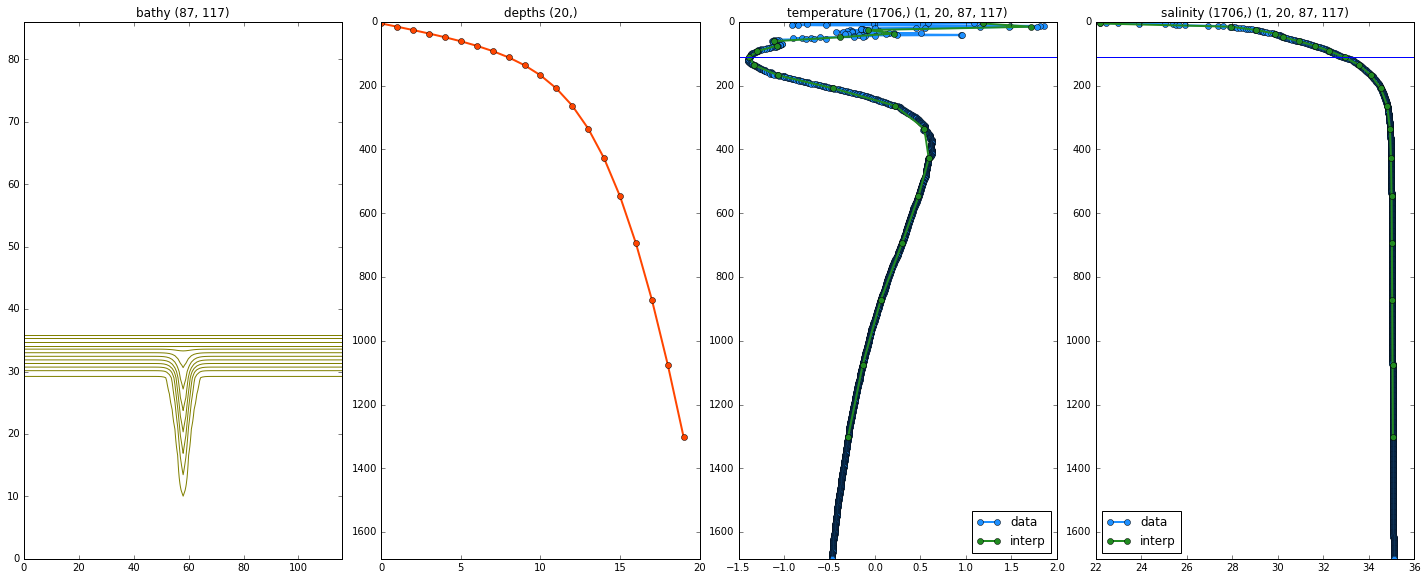

In [88]:
model_X, model_Y, model_bathy = gyre_X, gyre_Y, gyre_bathy
data_dept = prof_depth
fig = plot_interpolations(votemper_gyre, vosaline_gyre, data_salt, data_temp, data_dept, vertical_spacing, 
                          model_X, model_Y, model_bathy)

# Save netcdf file